This notebook uses kaggle's crowd counting dataset found in https://www.kaggle.com/datasets/fmena14/crowd-counting/data to compare different pretrained CNN models (resnet50, vgg19, inception v3, mobilenet) using transfer learning

### 1. Introduction

In [38]:
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score
import itertools

from keras.utils import to_categorical # convert to one-hot-encoding
from keras.models import *
from keras.layers import *
from keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import vgg16, inception_v3, resnet50, VGG19
from tensorflow.keras import backend

sns.set(style='white', context='notebook', palette='deep')

In [39]:
def add_one_to_one_correlation_line(ax, min_factor=1, max_factor=1, **plot_kwargs):
    lim_min, lim_max = pd.DataFrame([ax.get_ylim(), ax.get_xlim()]).agg({0: 'min', 1: 'max'})
    lim_min *= min_factor
    lim_max *= max_factor
    plot_kwargs_internal = dict(color='grey', ls='--')
    plot_kwargs_internal.update(plot_kwargs)
    ax.plot([lim_min, lim_max], [lim_min, lim_max], **plot_kwargs_internal)
    ax.set_ylim([lim_min, lim_max])
    ax.set_xlim([lim_min, lim_max])


# 2. Data preparation
## 2.1 Load and review data

In [40]:
# Load the data
df = pd.read_csv("Dataset\labels.csv")

In [41]:
# Map each id to its appropriate file name
df['image_name'] = df['id'].map('seq_{:06d}.jpg'.format)

In [42]:
df.describe()

id        count
count  2000.000000  2000.000000
mean   1000.500000    31.157500
std     577.494589     6.945417
min       1.000000    13.000000
25%     500.750000    26.000000
50%    1000.500000    31.000000
75%    1500.250000    36.000000
max    2000.000000    53.000000

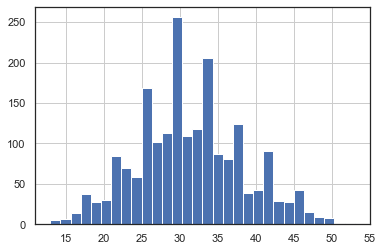

In [43]:
df['count'].hist(bins=30);

## 2.2 Setup data generator with optional augmentation 

In order to avoid overfitting, we need to expand artificially our  dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce variations.

For example:
The people are not clear
The scale is not the same (people taller/larger/smaller/...etc.)
The image is rotated
The angle/lighting of the image is different

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.

in our case and after several trials, shifting(both height and width), rotations, and zooming resulted in the disapperance of some of the crowd in the photo, resulting in an untrue label which means the loss/error/accuracy will be even lower for all models based on wrong labels. so we decided not to preform these transformations.

ImageDataGenerator applies augmentations on-the-fly during training rather than creating new images and saving them. The augmented images are generated each time they are needed for a training batch, which means the actual dataset size remains the same, but the model sees different augmented versions of the images during training.

In [44]:
# Setup some constants
size = 224
batch_size = 64

In [45]:
# ImageDataGenerator - with defined augmentaions
datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale the pixels to [0,1]. This seems to work well with pretrained models.
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    #rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
    #zoom_range = 0.001, # Randomly zoom image 
    #width_shift_range=0.001,  # randomly shift images horizontally (fraction of total width)
    #height_shift_range=0.001,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,
    validation_split=0.2,  # 20% of data randomly assigned to validation
    
    # This one is important:
    preprocessing_function=resnet50.preprocess_input,  # Whenever working with a pretrained model, it is said to be essential to use its provided preprocess
)

## 2.3 Load image data
We use the defined ImageDataGenerator to read the images using the dataframe we read earlier.

In [46]:
flow_params = dict(
    dataframe=df,
    directory='Dataset/frames/frames',
    x_col="image_name",
    y_col="count",
    weight_col=None,
    target_size=(size, size),
    color_mode='rgb',
    class_mode="raw",
    batch_size=batch_size,
    shuffle=True,
    seed=0,
)

# The dataset is split to training and validation sets at this point
train_generator = datagen.flow_from_dataframe(
    subset='training',
    **flow_params
)
valid_generator = datagen.flow_from_dataframe(
    subset='validation',
    **flow_params
)

Found 1600 validated image filenames.
Found 400 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

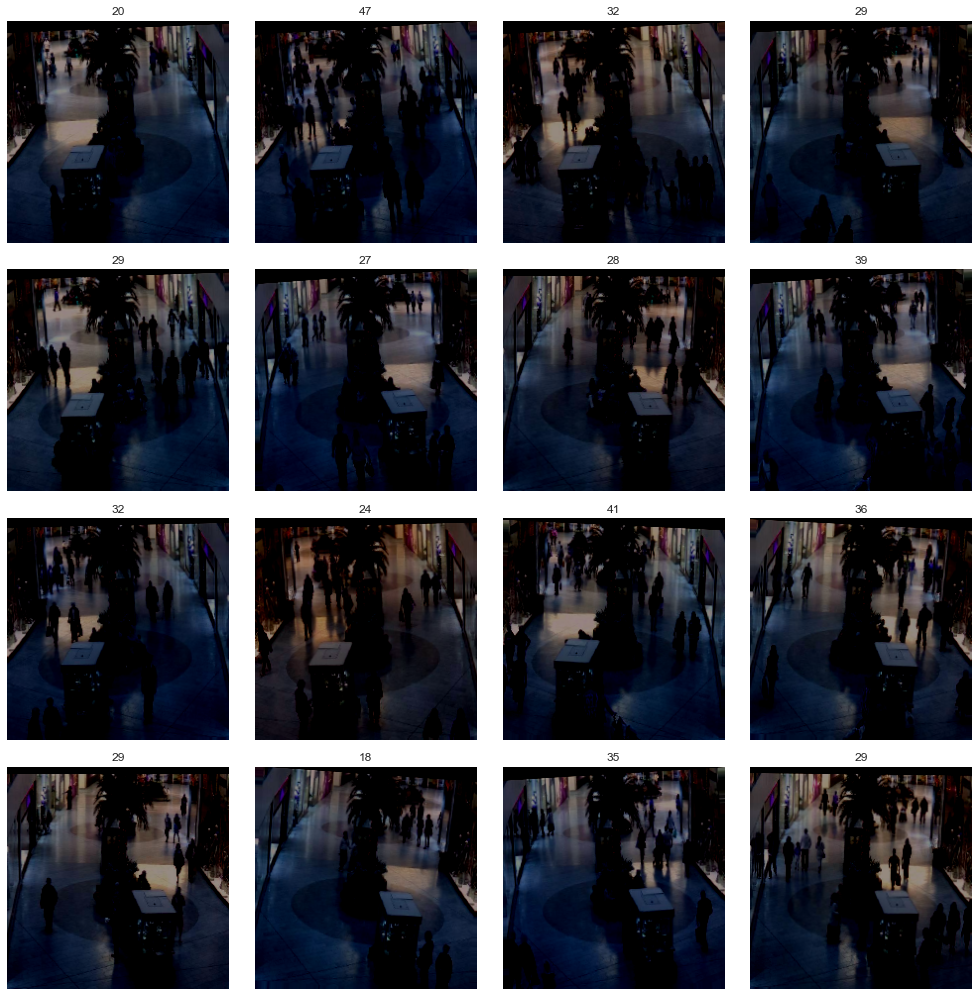

In [47]:
batch = next(train_generator)
fig, axes = plt.subplots(4, 4, figsize=(14, 14))
axes = axes.flatten()
for i in range(16):
    ax = axes[i]
    ax.imshow(batch[0][i])
    ax.axis('off')
    ax.set_title(batch[1][i])
plt.tight_layout()
plt.show()

In [25]:
# Print the number of images in the training and validation sets
num_training_images = train_generator.samples
num_validation_images = valid_generator.samples

print(f'Number of images in the training set: {num_training_images}')
print(f'Number of images in the validation set: {num_validation_images}')


Number of images in the training set: 1600
Number of images in the validation set: 400


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

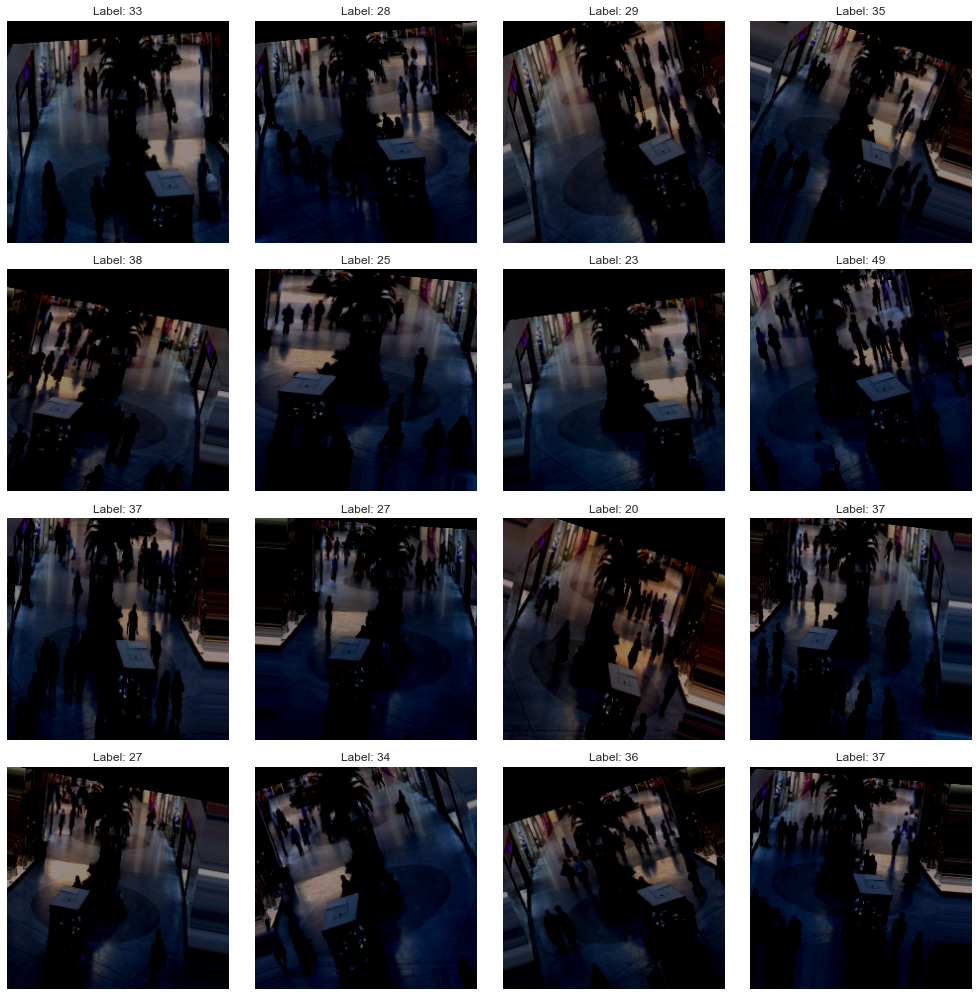

In [26]:
# Visualize some augmented images
batch = next(train_generator)
fig, axes = plt.subplots(4, 4, figsize=(14, 14))
axes = axes.flatten()
for i in range(16):
    img = batch[0][i]
    ax = axes[i]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Label: {batch[1][i]}')
plt.tight_layout()
plt.show()


## 3. Models laoding and training (transfer learning)

### RESNET50

#### 3.1 Load and modify the pretrained model

loading the pre-trained model 
adding a global average pooling layer after the last convolutional block
Removing the last fully connected layer and instead add a (dense, 1024, relu) fully connected layer with only 1 output (the number of people in the image)

In [11]:
base_model1 = resnet50.ResNet50(
    weights='imagenet',  # Load the pretrained weights, trained on the ImageNet dataset.
    include_top=False,  # We don't include the fully-connected layer at the top of the network - we need to modify the top.
    input_shape=(size, size, 3),  # 224x224 was the original size ResNet was trained on, so I decided to use this.
    pooling='avg',  # A global average pooling layer will be added after the last convolutional block.
)

In [13]:
# Here we change the top (the last parts) of the network.
x = base_model1.output  # Since we used pooling='avg', the output is of the pooling layer
x = Dense(1024, activation='relu')(x)  # We add a single fully-connected layer
predictions = Dense(1, activation='linear')(x)  # This is the new output layer - notice only 1 output, this will correspond to the number of people in the image

In [14]:
model1 = Model(inputs=base_model1.input, outputs=predictions)

##### freeze all but the last 7 layers (for transfer learning)

The purpose of this code is to leverage transfer learning by:

Freezing the initial layers of the pre-trained model (which contain more generic features learned from a large dataset like ImageNet) to retain their pre-learned weights.
Unfreezing the later layers to adapt the model to the specific features of your dataset by updating their weights during training.

In [15]:
k = -7
for layer in model1.layers[:k]:
    layer.trainable = False
print('Trainable:')
for layer in model1.layers[k:]:
    print(layer.name)
    layer.trainable = True

Trainable:
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out
avg_pool
dense
dense_1


In [16]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

## 3.2 Set the optimizer and annealer

Define the optimizer - this function will iteratively improve parameters in order to minimize the loss. 
The Adam optimization algorithm is an extension to stochastic gradient descent, which is usually more effective and fast.

In [17]:

optimizer = Adam(
    # The most important parameter is the learning rate - controls the amount that the weights are updated during eache round of training.
    learning_rate=0.001,
    # Additional parameters to play with:
#     beta_1=0.9,
#     beta_2=0.999,
#     epsilon=1e-07,
)

In [18]:
# Compile the model
model1.compile(
    optimizer=optimizer, 
    loss="mean_squared_error",  # This is a classic regression score - the lower the better
    metrics=['mean_absolute_error', 'mean_squared_error']
)

Set a learning rate annealer - to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function. 

The LR is decreased dynamically when the score is not improved. This keeps the advantage of the fast computation time with a high LR at the start.


In [19]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_mean_squared_error',  # Track the score on the validation set
    patience=3,  # Number of epochs in which no improvement is seen.
    verbose=1, 
    factor=0.2,  # Factor by which the LR is multiplied.
    min_lr=0.000001  # Don't go below this value for LR.
)

### Ensure GPU is detected by tensorflow for faster training

In [20]:
import tensorflow as tf

# List all physical devices detected by TensorFlow
print("All devices:", tf.config.list_physical_devices())

# Specifically check for available GPUs
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Additional details if GPUs are available (optional, but helpful for confirmation)
if tf.config.list_physical_devices('GPU'):
    for gpu in tf.config.list_physical_devices('GPU'):
        print("GPU Details:", tf.config.experimental.get_device_details(gpu))



All devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
GPU Details: {'device_name': 'NVIDIA GeForce RTX 3050 Ti Laptop GPU', 'compute_capability': (8, 6)}


In [21]:
#Use TensorFlow's mixed precision training which can reduce memory usage and also speed up training by utilizing float16 calculations:
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU, compute capability 8.6


In [22]:
with tf.device('/device:GPU:0'):
    # Fit the model
    history1 = model1.fit(
        train_generator,
        epochs=50,  # 50 epochs seems to have reached the minimal loss for this setup
        validation_data=valid_generator,
        verbose=2, 
        callbacks=[learning_rate_reduction],
    )
print('\nDone.')

Epoch 1/50
25/25 - 12s - loss: 128.2574 - mean_absolute_error: 8.0148 - mean_squared_error: 128.2574 - val_loss: 1939.6605 - val_mean_absolute_error: 43.6808 - val_mean_squared_error: 1939.6605 - lr: 0.0010 - 12s/epoch - 492ms/step
Epoch 2/50
25/25 - 7s - loss: 33.3561 - mean_absolute_error: 4.6378 - mean_squared_error: 33.3561 - val_loss: 849.6994 - val_mean_absolute_error: 28.6639 - val_mean_squared_error: 849.6994 - lr: 0.0010 - 7s/epoch - 267ms/step
Epoch 3/50
25/25 - 7s - loss: 30.0727 - mean_absolute_error: 4.3966 - mean_squared_error: 30.0727 - val_loss: 516.8967 - val_mean_absolute_error: 22.1322 - val_mean_squared_error: 516.8967 - lr: 0.0010 - 7s/epoch - 262ms/step
Epoch 4/50
25/25 - 7s - loss: 31.1239 - mean_absolute_error: 4.4652 - mean_squared_error: 31.1239 - val_loss: 498.6582 - val_mean_absolute_error: 21.7317 - val_mean_squared_error: 498.6582 - lr: 0.0010 - 7s/epoch - 262ms/step
Epoch 5/50
25/25 - 7s - loss: 26.9776 - mean_absolute_error: 4.1764 - mean_squared_error: 

## VGG19

In [23]:
base_model_VGG19 = VGG19(
    include_top=False, 
    weights='imagenet', 
    input_shape=(size, size, 3),
    pooling='avg',
)

In [24]:
# Here we change the top (the last parts) of the network.
x = base_model_VGG19.output  # Since we used pooling='avg', the output is of the pooling layer
x = Dense(1024, activation='relu')(x)  # We add a single fully-connected layer
predictions = Dense(1, activation='linear')(x)  # This is the new output layer - notice only 1 output, this will correspond to the number of people in the image

In [25]:
model3 = Model(inputs=base_model_VGG19.input, outputs=predictions)

In [26]:
k = -7
for layer in model3.layers[:k]:
    layer.trainable = False
print('Trainable:')
for layer in model3.layers[k:]:
    print(layer.name)
    layer.trainable = True

Trainable:
block5_conv2
block5_conv3
block5_conv4
block5_pool
global_average_pooling2d
dense_2
dense_3


In [27]:
model3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

## 3.2 Set the optimizer and annealer

In [28]:
# Define the optimizer - this function will iteratively improve parameters in order to minimise the loss. 
# The Adam optimization algorithm is an extension to stochastic gradient descent, which is usually more effective and fast.
optimizer = Adam(
    # The most important parameter is the learning rate - controls the amount that the weights are updated during eache round of training.
    learning_rate=0.001,
    # Additional parameters to play with:
#     beta_1=0.9,
#     beta_2=0.999,
#     epsilon=1e-07,
)

In [29]:
# Compile the model
model3.compile(
    optimizer=optimizer, 
    loss="mean_squared_error",  # This is a classic regression score - the lower the better
    metrics=['mean_absolute_error', 'mean_squared_error']
)

In [30]:
# Set a learning rate annealer - to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function. 
# The LR is decreased dynamically when the score is not improved. This keeps the advantage of the fast computation time with a high LR at the start.
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_mean_squared_error',  # Track the score on the validation set
    patience=3,  # Number of epochs in which no improvement is seen.
    verbose=1, 
    factor=0.2,  # Factor by which the LR is multiplied.
    min_lr=0.000001  # Don't go below this value for LR.
)

In [31]:
with tf.device('/device:GPU:0'):
    # Fit the model
    history3 = model3.fit(
        train_generator,
        epochs=50,  # 50 epochs seems to have reached the minimal loss for this setup
        validation_data=valid_generator,
        verbose=2, 
        callbacks=[learning_rate_reduction],
    )
print('\nDone.')

Epoch 1/50
25/25 - 13s - loss: 562.1312 - mean_absolute_error: 20.8510 - mean_squared_error: 562.1442 - val_loss: 103.3750 - val_mean_absolute_error: 8.5791 - val_mean_squared_error: 103.3777 - lr: 0.0010 - 13s/epoch - 502ms/step
Epoch 2/50
25/25 - 6s - loss: 73.5644 - mean_absolute_error: 6.9026 - mean_squared_error: 73.5699 - val_loss: 51.4863 - val_mean_absolute_error: 5.8901 - val_mean_squared_error: 51.4849 - lr: 0.0010 - 6s/epoch - 255ms/step
Epoch 3/50
25/25 - 6s - loss: 32.6106 - mean_absolute_error: 4.5338 - mean_squared_error: 32.6065 - val_loss: 16.3781 - val_mean_absolute_error: 3.2188 - val_mean_squared_error: 16.3815 - lr: 0.0010 - 6s/epoch - 254ms/step
Epoch 4/50
25/25 - 6s - loss: 13.5227 - mean_absolute_error: 2.9000 - mean_squared_error: 13.5227 - val_loss: 10.2131 - val_mean_absolute_error: 2.5153 - val_mean_squared_error: 10.2127 - lr: 0.0010 - 6s/epoch - 250ms/step
Epoch 5/50
25/25 - 6s - loss: 9.6498 - mean_absolute_error: 2.4648 - mean_squared_error: 9.6497 - val

## INCEPTION (Googlenet) v3

In [32]:
from tensorflow.keras.applications import InceptionV3

# Load the base model
base_model_InceptionV3 = InceptionV3(
    include_top=False, 
    weights='imagenet', 
    input_shape=(size, size, 3),
    pooling='avg',
)

In [33]:
# Modify the top of the model
x = base_model_InceptionV3.output
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='linear')(x)

In [34]:
# Define the model
model_inception = Model(inputs=base_model_InceptionV3.input, outputs=predictions)

In [35]:
# Freeze the base model layers
k = -7
for layer in model_inception.layers[:k]:
    layer.trainable = False
print('Trainable:')
for layer in model_inception.layers[k:]:
    print(layer.name)
    layer.trainable = True

Trainable:
mixed9_1
concatenate_1
activation_93
mixed10
global_average_pooling2d_1
dense_4
dense_5


In [36]:
# Compile the model
optimizer_inception = Adam(learning_rate=0.001)
model_inception.compile(
    optimizer=optimizer_inception, 
    loss="mean_squared_error", 
    metrics=['mean_absolute_error', 'mean_squared_error']
)


In [37]:
# Set up the learning rate reduction
learning_rate_reduction_inception = ReduceLROnPlateau(
    monitor='val_mean_squared_error', 
    patience=3, 
    verbose=1, 
    factor=0.2, 
    min_lr=0.000001
)


In [38]:
# Train the model
with tf.device('/device:GPU:0'):
    history_inception = model_inception.fit(
        train_generator,
        epochs=50, 
        validation_data=valid_generator,
        verbose=2, 
        callbacks=[learning_rate_reduction_inception],
    )
print('\nDone.')

Epoch 1/50
25/25 - 10s - loss: inf - mean_absolute_error: 15.4720 - mean_squared_error: 385.6755 - val_loss: 46.8800 - val_mean_absolute_error: 5.5942 - val_mean_squared_error: 46.8768 - lr: 0.0010 - 10s/epoch - 383ms/step
Epoch 2/50
25/25 - 4s - loss: 35.5537 - mean_absolute_error: 4.7532 - mean_squared_error: 35.5512 - val_loss: 27.0312 - val_mean_absolute_error: 4.2235 - val_mean_squared_error: 27.0297 - lr: 0.0010 - 4s/epoch - 179ms/step
Epoch 3/50
25/25 - 4s - loss: 24.7806 - mean_absolute_error: 3.9370 - mean_squared_error: 24.7836 - val_loss: 21.4662 - val_mean_absolute_error: 3.6944 - val_mean_squared_error: 21.4676 - lr: 0.0010 - 4s/epoch - 178ms/step
Epoch 4/50
25/25 - 4s - loss: 19.7056 - mean_absolute_error: 3.5339 - mean_squared_error: 19.7038 - val_loss: 18.7269 - val_mean_absolute_error: 3.4131 - val_mean_squared_error: 18.7265 - lr: 0.0010 - 4s/epoch - 174ms/step
Epoch 5/50
25/25 - 5s - loss: 17.4991 - mean_absolute_error: 3.3079 - mean_squared_error: 17.5012 - val_loss

## MobileNet

In [39]:
from tensorflow.keras.applications import MobileNet

# Load the base model
base_model_MobileNet = MobileNet(
    include_top=False, 
    weights='imagenet', 
    input_shape=(size, size, 3),
    pooling='avg',
)


In [40]:
# Modify the top of the model
x = base_model_MobileNet.output
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='linear')(x)

In [41]:
# Define the model
model_mobilenet = Model(inputs=base_model_MobileNet.input, outputs=predictions)

In [42]:
# Freeze the base model layers
k = -7
for layer in model_mobilenet.layers[:k]:
    layer.trainable = False
print('Trainable:')
for layer in model_mobilenet.layers[k:]:
    print(layer.name)
    layer.trainable = True

Trainable:
conv_dw_13_relu
conv_pw_13
conv_pw_13_bn
conv_pw_13_relu
global_average_pooling2d_2
dense_6
dense_7


In [43]:
# Compile the model
optimizer_mobilenet = Adam(learning_rate=0.001)
model_mobilenet.compile(
    optimizer=optimizer_mobilenet, 
    loss="mean_squared_error", 
    metrics=['mean_absolute_error', 'mean_squared_error']
)

In [44]:
# Set up the learning rate reduction
learning_rate_reduction_mobilenet = ReduceLROnPlateau(
    monitor='val_mean_squared_error', 
    patience=3, 
    verbose=1, 
    factor=0.2, 
    min_lr=0.000001
)

In [45]:
# Train the model
with tf.device('/device:GPU:0'):
    history_mobilenet = model_mobilenet.fit(
        train_generator,
        epochs=50, 
        validation_data=valid_generator,
        verbose=2, 
        callbacks=[learning_rate_reduction_mobilenet],
    )
print('\nDone.')

Epoch 1/50
25/25 - 7s - loss: inf - mean_absolute_error: 14.3643 - mean_squared_error: 356.6802 - val_loss: inf - val_mean_absolute_error: 108.3944 - val_mean_squared_error: 11789.2588 - lr: 0.0010 - 7s/epoch - 266ms/step
Epoch 2/50
25/25 - 4s - loss: 14.4227 - mean_absolute_error: 2.9817 - mean_squared_error: 14.4221 - val_loss: inf - val_mean_absolute_error: 86.8570 - val_mean_squared_error: 7581.1211 - lr: 0.0010 - 4s/epoch - 172ms/step
Epoch 3/50
25/25 - 4s - loss: 7.3620 - mean_absolute_error: 2.1548 - mean_squared_error: 7.3624 - val_loss: inf - val_mean_absolute_error: 65.1095 - val_mean_squared_error: 4271.4346 - lr: 0.0010 - 4s/epoch - 173ms/step
Epoch 4/50
25/25 - 4s - loss: 7.7564 - mean_absolute_error: 2.2169 - mean_squared_error: 7.7575 - val_loss: inf - val_mean_absolute_error: 51.1883 - val_mean_squared_error: 2645.5576 - lr: 0.0010 - 4s/epoch - 170ms/step
Epoch 5/50
25/25 - 4s - loss: 4.5869 - mean_absolute_error: 1.6939 - mean_squared_error: 4.5872 - val_loss: inf - va

# 4. Evaluate the model
## 4.1 Training and validation curves

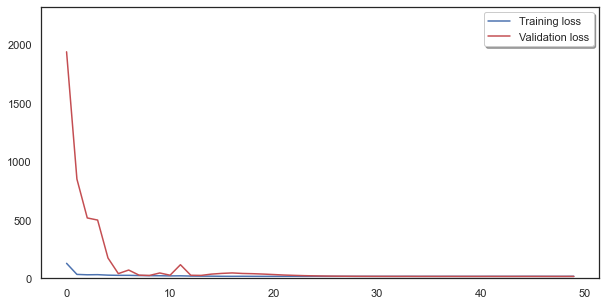

In [46]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(history1.history['loss'], color='b', label="Training loss")
ax.plot(history1.history['val_loss'], color='r', label="Validation loss",axes =ax)
ax.set_ylim(top=np.max(history1.history['val_loss'])*1.2, bottom=0)
legend = ax.legend(loc='best', shadow=True)

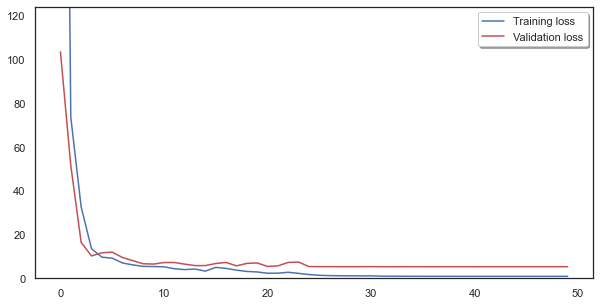

In [47]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(history3.history['loss'], color='b', label="Training loss")
ax.plot(history3.history['val_loss'], color='r', label="Validation loss",axes =ax)
ax.set_ylim(top=np.max(history3.history['val_loss'])*1.2, bottom=0)
legend = ax.legend(loc='best', shadow=True)

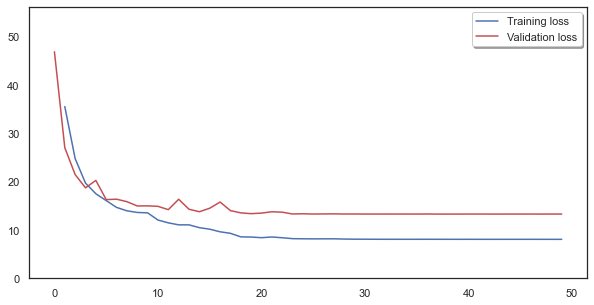

In [48]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(history_inception.history['loss'], color='b', label="Training loss")
ax.plot(history_inception.history['val_loss'], color='r', label="Validation loss",axes =ax)
ax.set_ylim(top=np.max(history_inception.history['val_loss'])*1.2, bottom=0)
legend = ax.legend(loc='best', shadow=True)

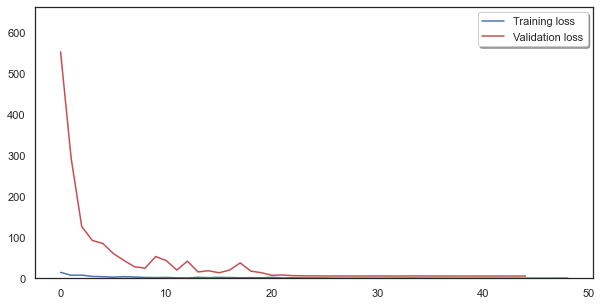

In [54]:
# Filter out NaN or Inf values
valid_loss = [loss for loss in history_mobilenet.history['loss'] if np.isfinite(loss)]
valid_val_loss = [val_loss for val_loss in history_mobilenet.history['val_loss'] if np.isfinite(val_loss)]

# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(valid_loss, color='b', label="Training loss")
ax.plot(valid_val_loss, color='r', label="Validation loss",axes =ax)
# Set axis limits, check for valid limits
if valid_val_loss:
    max_val_loss = np.max(valid_val_loss) * 1.2
    ax.set_ylim(top=max_val_loss, bottom=0)
else:
    ax.set_ylim(top=1.0, bottom=0)  # Set a default top limit if valid_val_loss is empty
legend = ax.legend(loc='best', shadow=True)

In [75]:
# Predict on entire validation set, to be able to review the predictions manually
valid_generator.reset()
all_labels = []
all_pred = []
resnet_images = []

for i in range(len(valid_generator)):
    x = next(valid_generator)
    pred_i = model1.predict(x[0])[:,0]
    labels_i = x[1]
    all_labels.append(labels_i)
    all_pred.append(pred_i)
    resnet_images.append(x[0])  # Store the images for visualization

#     print(np.shape(pred_i), np.shape(labels_i))

cat_labels_resnet = np.concatenate(all_labels)
cat_pred_resnet = np.concatenate(all_pred)
resnet_images = np.concatenate(resnet_images)


1/1 [==============================] - 0s 28ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


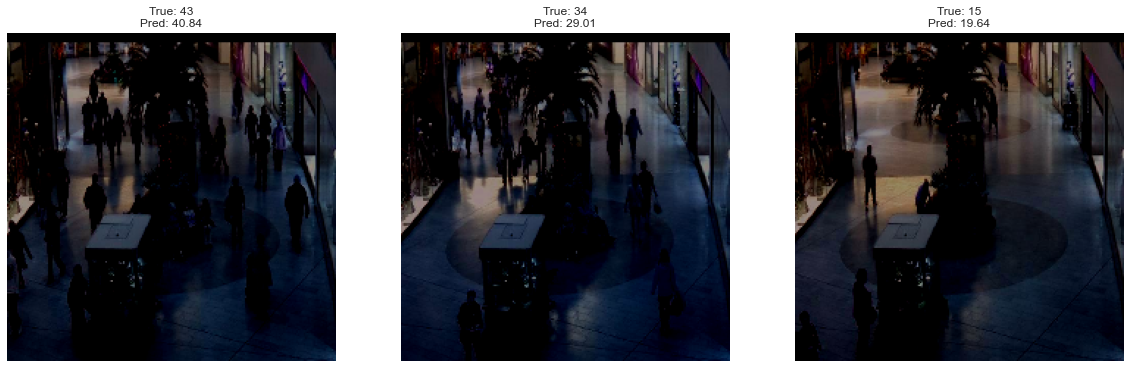

In [78]:
# Number of images to display
num_images = 3

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(20, 8))
axes = axes.flatten()
for i in range(num_images):
    img = resnet_images[i]
    true_label = cat_labels_resnet[i]
    pred_label = cat_pred_resnet[i]
    
    # Display the image
    ax = axes[i]
    ax.imshow(img)
    ax.axis('off')
    
    # Set the title
    ax.set_title(f'True: {true_label}\nPred: {pred_label:.2f}', fontsize=12)

In [81]:
# Predict on entire validation set, to be able to review the predictions manually
valid_generator.reset()
all_labels = []
all_pred = []
vgg_images = []
for i in range(len(valid_generator)):
    x = next(valid_generator)
    pred_i = model3.predict(x[0])[:,0]
    labels_i = x[1]
    all_labels.append(labels_i)
    all_pred.append(pred_i)
    vgg_images.append(x[0])
#     print(np.shape(pred_i), np.shape(labels_i))

cat_labels_vgg19 = np.concatenate(all_labels)
cat_pred_vgg19 = np.concatenate(all_pred)
vgg_images = np.concatenate(vgg_images)

1/1 [==============================] - 0s 23ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


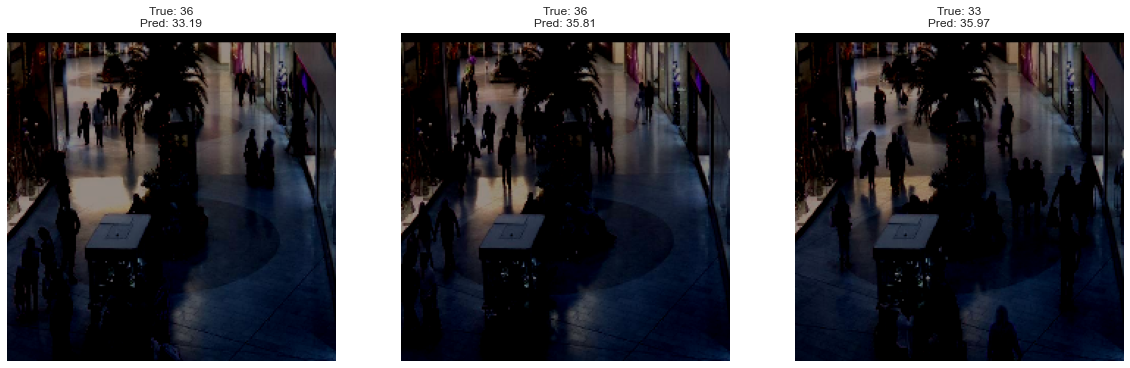

In [83]:
# Number of images to display
num_images = 3

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(20, 8))
axes = axes.flatten()
for i in range(num_images):
    img = vgg_images[i]
    true_label = cat_labels_vgg19[i]
    pred_label = cat_pred_vgg19[i]
    
    # Display the image
    ax = axes[i]
    ax.imshow(img)
    ax.axis('off')
    
    # Set the title
    ax.set_title(f'True: {true_label}\nPred: {pred_label:.2f}', fontsize=12)

In [86]:
# Predict on entire validation set, to be able to review the predictions manually
valid_generator.reset()
all_labels = []
all_pred = []
inception_images = []
for i in range(len(valid_generator)):
    x = next(valid_generator)
    pred_i = model_inception.predict(x[0])[:,0]
    labels_i = x[1]
    all_labels.append(labels_i)
    all_pred.append(pred_i)
    inception_images.append(x[0])
#     print(np.shape(pred_i), np.shape(labels_i))

cat_labels_inception = np.concatenate(all_labels)
cat_pred_inception = np.concatenate(all_pred)
inception_images = np.concatenate(inception_images)

1/1 [==============================] - 0s 34ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


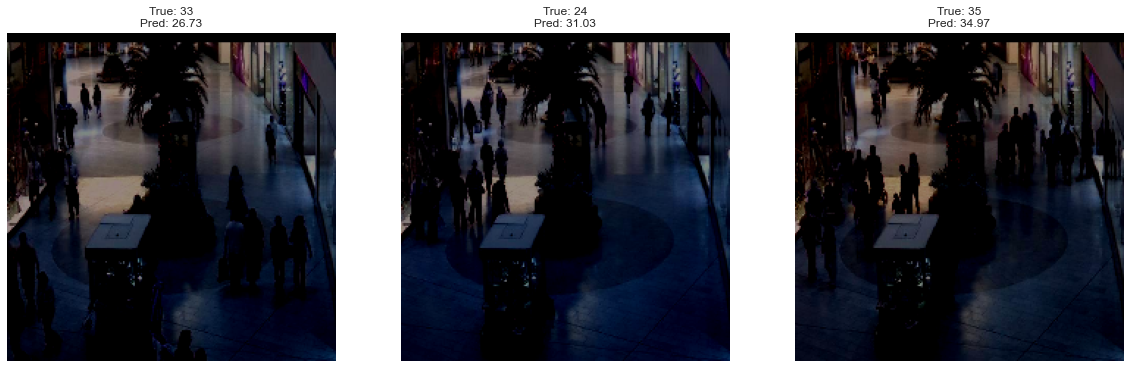

In [89]:
# Number of images to display
num_images = 3

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(20, 8))
axes = axes.flatten()
for i in range(num_images):
    img = inception_images[i]
    true_label = cat_labels_inception[i]
    pred_label = cat_pred_inception[i]
    
    # Display the image
    ax = axes[i]
    ax.imshow(img)
    ax.axis('off')
    
    # Set the title
    ax.set_title(f'True: {true_label}\nPred: {pred_label:.2f}', fontsize=12)

In [88]:
# Predict on entire validation set, to be able to review the predictions manually
valid_generator.reset()
all_labels = []
all_pred = []
mobilenet_images = []
for i in range(len(valid_generator)):
    x = next(valid_generator)
    pred_i = model_mobilenet.predict(x[0])[:,0]
    labels_i = x[1]
    all_labels.append(labels_i)
    all_pred.append(pred_i)
    mobilenet_images.append(x[0])
#     print(np.shape(pred_i), np.shape(labels_i))

cat_labels_mobilenet = np.concatenate(all_labels)
cat_pred_mobilenet = np.concatenate(all_pred)
mobilenet_images = np.concatenate(mobilenet_images)

1/1 [==============================] - 0s 23ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


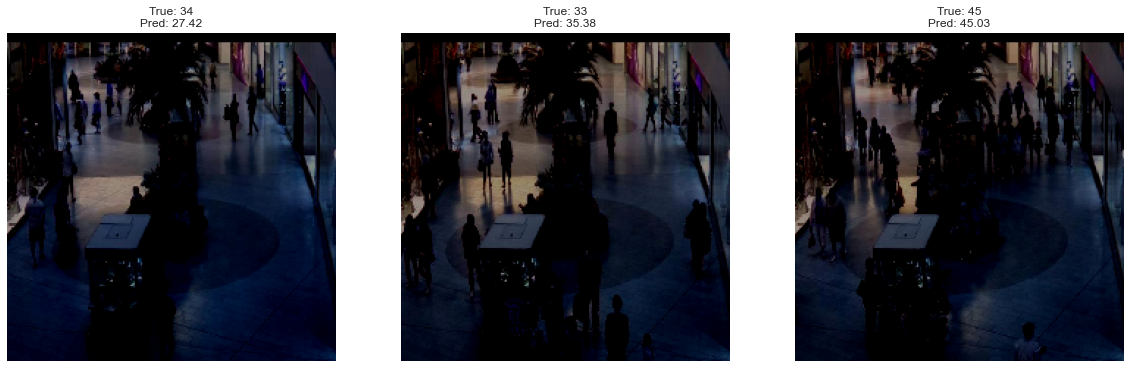

In [90]:
# Number of images to display
num_images = 3

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(20, 8))
axes = axes.flatten()
for i in range(num_images):
    img = mobilenet_images[i]
    true_label = cat_labels_mobilenet[i]
    pred_label = cat_pred_mobilenet[i]
    
    # Display the image
    ax = axes[i]
    ax.imshow(img)
    ax.axis('off')
    
    # Set the title
    ax.set_title(f'True: {true_label}\nPred: {pred_label:.2f}', fontsize=12)

c:\Python310\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


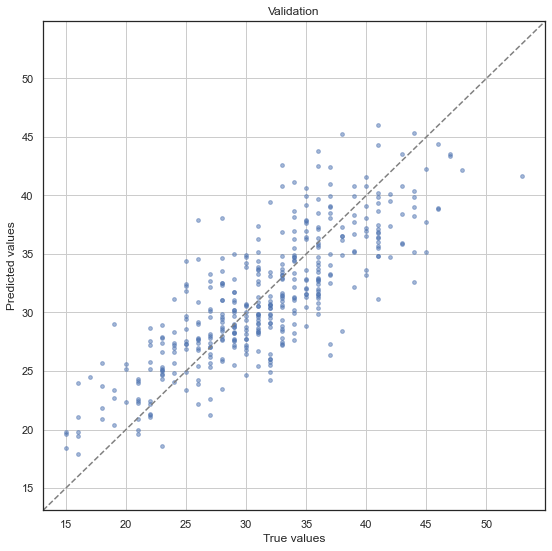

In [64]:
df_predictions_resnet = pd.DataFrame({'True values': cat_labels_resnet, 'Predicted values': cat_pred_resnet})
ax = df_predictions_resnet.plot.scatter('True values', 'Predicted values', alpha=0.5, s=14, figsize=(9,9))
ax.grid(axis='both')
add_one_to_one_correlation_line(ax)
ax.set_title('Validation')

plt.show()

c:\Python310\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


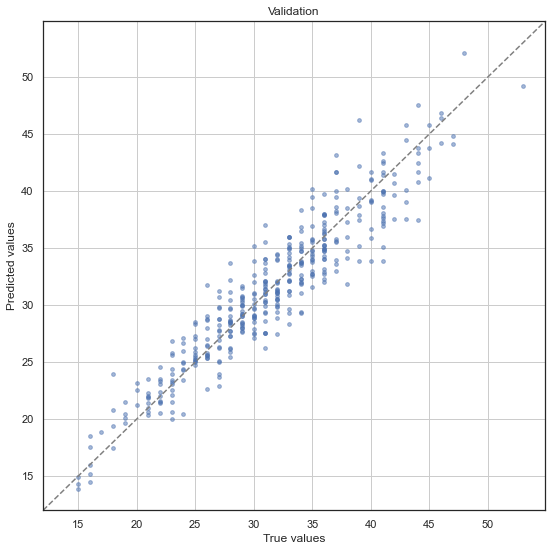

In [66]:
df_predictions_vgg19 = pd.DataFrame({'True values': cat_labels_vgg19, 'Predicted values': cat_pred_vgg19})
ax = df_predictions_vgg19.plot.scatter('True values', 'Predicted values', alpha=0.5, s=14, figsize=(9,9))
ax.grid(axis='both')
add_one_to_one_correlation_line(ax)
ax.set_title('Validation')

plt.show()

c:\Python310\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


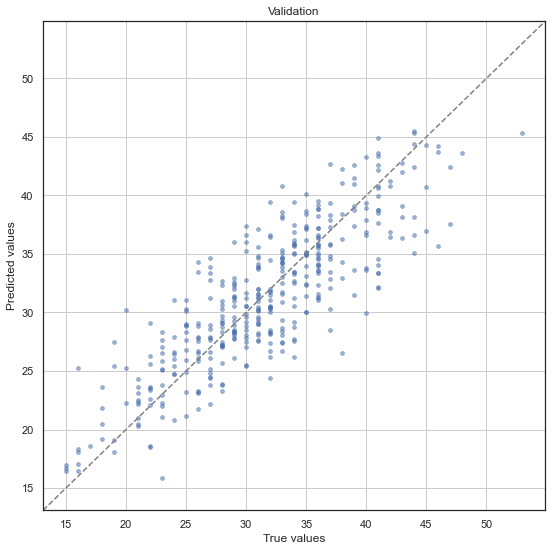

In [67]:
df_predictions_inception = pd.DataFrame({'True values': cat_labels_inception, 'Predicted values': cat_pred_inception})
ax = df_predictions_inception.plot.scatter('True values', 'Predicted values', alpha=0.5, s=14, figsize=(9,9))
ax.grid(axis='both')
add_one_to_one_correlation_line(ax)
ax.set_title('Validation')

plt.show()

c:\Python310\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


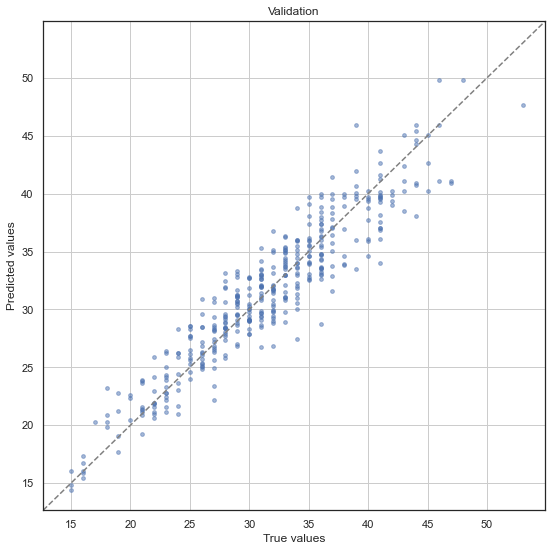

In [68]:
df_predictions_mobilenet = pd.DataFrame({'True values': cat_labels_mobilenet, 'Predicted values': cat_pred_mobilenet})
ax = df_predictions_mobilenet.plot.scatter('True values', 'Predicted values', alpha=0.5, s=14, figsize=(9,9))
ax.grid(axis='both')
add_one_to_one_correlation_line(ax)
ax.set_title('Validation')

plt.show()

In [93]:
# Compute MAE
mae_resnet = mean_absolute_error(cat_labels_resnet, cat_pred_resnet)

# Compute MSE
mse_resnet = mean_squared_error(cat_labels_resnet, cat_pred_resnet)

# Compute R² Score
r2_resnet = r2_score(cat_labels_resnet, cat_pred_resnet)

print(f'MAE: {mae_resnet:.2f}')
print(f'MSE: {mse_resnet:.2f}')
print(f'R² Score: {r2_resnet:.2f}')

MAE: 3.21
MSE: 15.89
R² Score: 0.65


In [105]:
# Define a threshold percentage
threshold_percentage = 0.10

# Calculate the percentage of predictions within the threshold
within_threshold = np.abs(cat_pred_resnet - cat_labels_resnet) / cat_labels_resnet < threshold_percentage
resnet_accuracy_within_threshold = np.mean(within_threshold) * 100

print(f'Percentage of predictions within {threshold_percentage*100}% of the true value: {resnet_accuracy_within_threshold:.2f}%')


Percentage of predictions within 10.0% of the true value: 57.50%


In [94]:
# Compute MAE
mae_vgg19 = mean_absolute_error(cat_labels_vgg19, cat_pred_vgg19)

# Compute MSE
mse_vgg19 = mean_squared_error(cat_labels_vgg19, cat_pred_vgg19)

# Compute R² Score
r2_vgg19 = r2_score(cat_labels_vgg19, cat_pred_vgg19)

print(f'MAE: {mae_vgg19:.2f}')
print(f'MSE: {mse_vgg19:.2f}')
print(f'R² Score: {r2_vgg19:.2f}')

MAE: 1.80
MSE: 5.30
R² Score: 0.88


In [104]:
# Define a threshold percentage
threshold_percentage = 0.10

# Calculate the percentage of predictions within the threshold
within_threshold = np.abs(cat_pred_vgg19 - cat_labels_vgg19) / cat_labels_vgg19 < threshold_percentage
vgg_accuracy_within_threshold = np.mean(within_threshold) * 100

print(f'Percentage of predictions within {threshold_percentage*100}% of the true value: {vgg_accuracy_within_threshold:.2f}%')


Percentage of predictions within 10.0% of the true value: 82.75%


In [95]:
# Compute MAE
mae_inception = mean_absolute_error(cat_labels_inception, cat_pred_inception)

# Compute MSE
mse_inception = mean_squared_error(cat_labels_inception, cat_pred_inception)

# Compute R² Score
r2_inception = r2_score(cat_labels_inception, cat_pred_inception)

print(f'MAE: {mae_inception:.2f}')
print(f'MSE: {mse_inception:.2f}')
print(f'R² Score: {r2_inception:.2f}')

MAE: 2.84
MSE: 13.29
R² Score: 0.71


In [103]:
# Define a threshold percentage
threshold_percentage = 0.10

# Calculate the percentage of predictions within the threshold
within_threshold = np.abs(cat_pred_inception - cat_labels_inception) / cat_labels_inception < threshold_percentage
inception_accuracy_within_threshold = np.mean(within_threshold) * 100

print(f'Percentage of predictions within {threshold_percentage*100}% of the true value: {inception_accuracy_within_threshold:.2f}%')


Percentage of predictions within 10.0% of the true value: 62.00%


In [97]:
# Compute MAE
mae_mobilenet = mean_absolute_error(cat_labels_mobilenet, cat_pred_mobilenet)

# Compute MSE
mse_mobilenet = mean_squared_error(cat_labels_mobilenet, cat_pred_mobilenet)

# Compute R² Score
r2_mobilenet = r2_score(cat_labels_mobilenet, cat_pred_mobilenet)

print(f'MAE: {mae_mobilenet:.2f}')
print(f'MSE: {mse_mobilenet:.2f}')
print(f'R² Score: {r2_mobilenet:.2f}')

MAE: 1.85
MSE: 5.54
R² Score: 0.88


In [102]:
# Define a threshold percentage
threshold_percentage = 0.10

# Calculate the percentage of predictions within the threshold
within_threshold = np.abs(cat_pred_mobilenet - cat_labels_mobilenet) / cat_labels_mobilenet < threshold_percentage
mobilenet_accuracy_within_threshold = np.mean(within_threshold) * 100

print(f'Percentage of predictions within {threshold_percentage*100}% of the true value: {mobilenet_accuracy_within_threshold:.2f}%')


Percentage of predictions within 10.0% of the true value: 82.00%


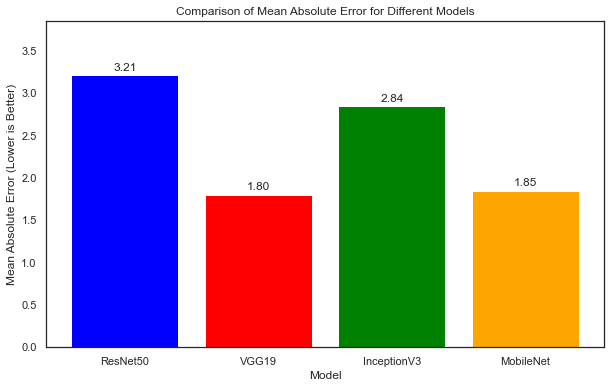

In [106]:
import matplotlib.pyplot as plt

# Data for bar plot
models = ['ResNet50', 'VGG19', 'InceptionV3', 'MobileNet']
mae_values = [mae_resnet, mae_vgg19, mae_inception, mae_mobilenet]

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(models, mae_values, color=['blue', 'red', 'green', 'orange'])

# Add labels and title
ax.set_ylabel('Mean Absolute Error (Lower is Better)')
ax.set_xlabel('Model')
ax.set_title('Comparison of Mean Absolute Error for Different Models')
ax.set_ylim(0, max(mae_values) * 1.2)

# Display the values on top of the bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Show plot
plt.show()


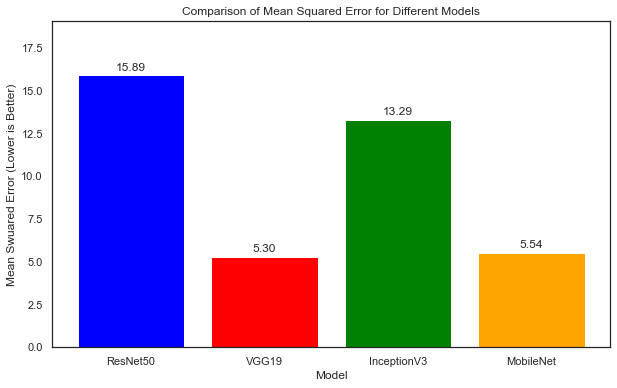

In [110]:

# Data for bar plot
models = ['ResNet50', 'VGG19', 'InceptionV3', 'MobileNet']
mae_values = [mse_resnet, mse_vgg19, mse_inception, mse_mobilenet]

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(models, mae_values, color=['blue', 'red', 'green', 'orange'])

# Add labels and title
ax.set_ylabel('Mean Swuared Error (Lower is Better)')
ax.set_xlabel('Model')
ax.set_title('Comparison of Mean Squared Error for Different Models')
ax.set_ylim(0, max(mae_values) * 1.2)

# Display the values on top of the bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')




(0.5204674556727006, 1.060177716942432)

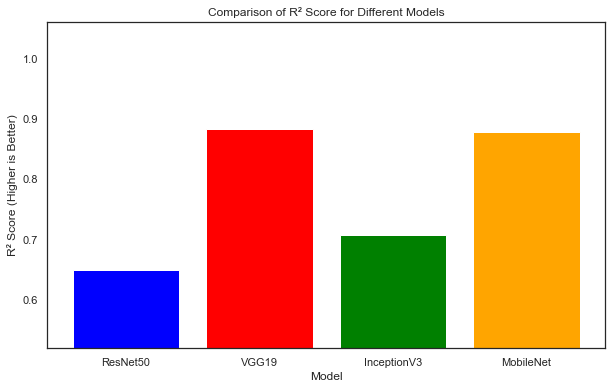

In [108]:

# Data for bar plot
models = ['ResNet50', 'VGG19', 'InceptionV3', 'MobileNet']
r2_values = [r2_resnet, r2_vgg19, r2_inception, r2_mobilenet]

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(models, r2_values, color=['blue', 'red', 'green', 'orange'])

# Add labels and title
ax.set_ylabel('R² Score (Higher is Better)')
ax.set_xlabel('Model')
ax.set_title('Comparison of R² Score for Different Models')
ax.set_ylim(min(r2_values) * 0.8, max(r2_values) * 1.2)  # Adjust y-axis to make sure all values are visible




(46.0, 99.3)

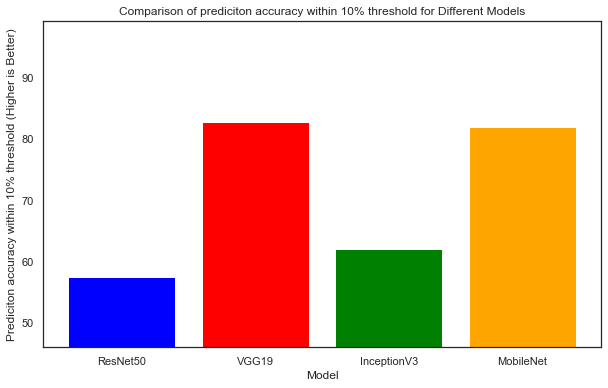

In [109]:

# Data for bar plot
models = ['ResNet50', 'VGG19', 'InceptionV3', 'MobileNet']
acc_values = [resnet_accuracy_within_threshold, vgg_accuracy_within_threshold, inception_accuracy_within_threshold, mobilenet_accuracy_within_threshold]

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(models, acc_values, color=['blue', 'red', 'green', 'orange'])

# Add labels and title
ax.set_ylabel('Prediciton accuracy within a 10% threshold (Higher is Better)')
ax.set_xlabel('Model')
ax.set_title('Comparison of prediciton accuracy within a 10% threshold for Different Models')
ax.set_ylim(min(acc_values) * 0.8, max(acc_values) * 1.2)  # Adjust y-axis to make sure all values are visible


